In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import tensorflow as tf
import numpy as np

### Loading the Data using torchvision

In [2]:
#Loading the image file and label mapping data
image_mapping_data = pd.read_csv(r"D:\Capstone\Data\ImageLabelMapping.csv")
image_mapping_data.head()

,filename,Label
0,L427F01330C01S03961Rp02052.jpg,0
1,L1083F00930C39S12674Ip.jpg,0
2,24_initial_1_1463_1463.JPG,0
3,L341F00167C01S00324Rp14178.jpg,1
4,L1084F02394C39S13931Ip.jpg,0


In [3]:
#splitting the data into training and validation sets with stratification  
from sklearn.model_selection import train_test_split

X = image_mapping_data['filename']
y = image_mapping_data['Label']
X_train, X_val, y_train, y_val =  train_test_split(X, y, test_size = 0.2, stratify=y)

In [4]:
#verifying if the stratification worked
from collections import Counter

print(Counter(y_train))
print(Counter(y_val))

Counter({0: 17241, 1: 3613})
Counter({0: 4311, 1: 903})


In [5]:
X_train = list(X_train)
y_train = list(y_train)
X_val = list(X_val)
y_val = list(y_val)

### Image Dataset Loader

In [6]:
#creating the custom Dataset class in pytorch.
import os
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.io import read_image
import cv2

RESCALE = 128

class ImageDataset(Dataset):
    def __init__(self, img_dir, img_files, img_labels, transform=None, target_transform=None):
        self.img_dir = img_dir
        self.img_files = img_files
        self.img_labels = img_labels
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_files[idx])
        image = cv2.imread(img_path, cv2.IMREAD_COLOR)
        image = cv2.resize(image, (RESCALE, RESCALE))
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        label = self.img_labels[idx]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [7]:
from torchvision import transforms
train_transform = transforms.Compose([transforms.ToTensor()])
val_transform = transforms.Compose([transforms.ToTensor()])

In [8]:
img_dir = "D:\Capstone\Data\data_train"
train_set = ImageDataset(img_dir, X_train, y_train, transform = train_transform)
val_set = ImageDataset(img_dir, X_val, y_val, transform = val_transform)

print("Training data size",train_set.__len__())
print("Validation data size",val_set.__len__())

Training data size 20854
Validation data size 5214


In [9]:
BATCH_SIZE = 10

train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True)
val_loader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True)

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


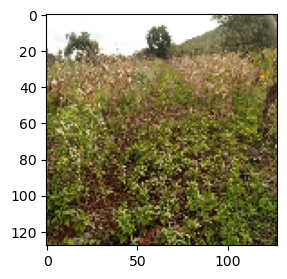

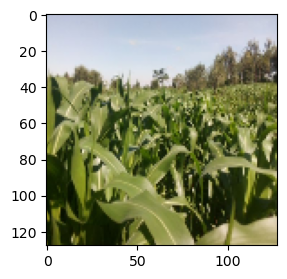

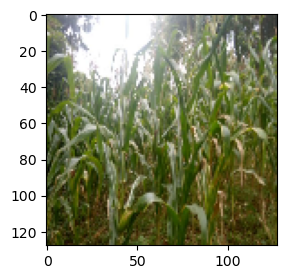

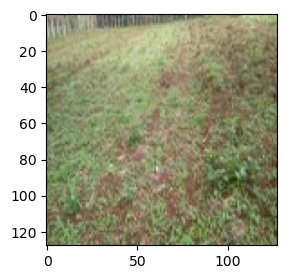

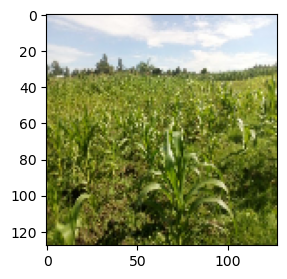

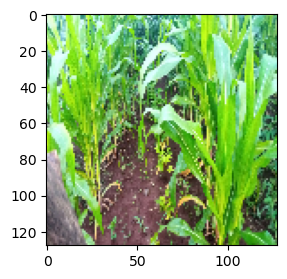

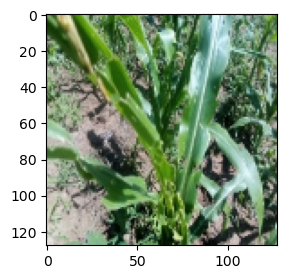

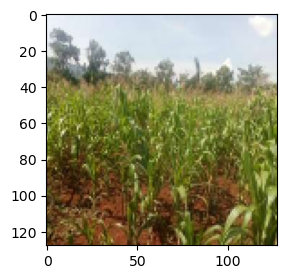

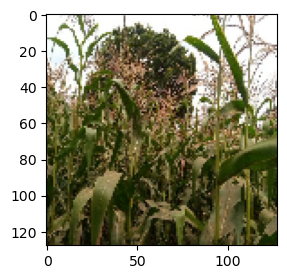

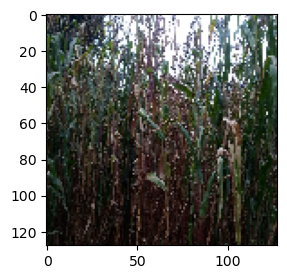

In [10]:
img, label = next(iter(train_loader))

# 0-NonDR, 1-DR 
print(label)

for i in img:
    plt.figure(figsize=(3,3))
    npimg = np.array(i)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


In [11]:
print(torch.min(img), torch.max(img))

tensor(0.) tensor(1.)


### Building the model

In [12]:
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch
from torchsummary import summary
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime

In [13]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


### Training Loop

In [14]:
def train_one_epoch(epoch_index, tb_writer, model, optimizer, loss_fn):
    running_loss = 0.
    last_loss = 0.

    # Here, we use enumerate(training_loader) instead of
    # iter(training_loader) so that we can track the batch
    # index and do some intra-epoch reporting
    for i, data in enumerate(train_loader):
        # Every data instance is an input + label pair
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        outputs = model(inputs)

        # Compute the loss and its gradients
        labels = labels.to(torch.float32)
        loss = loss_fn(outputs, inputs)
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        # Gather data and report
        running_loss += loss.item()
        if i % 1000 == 999:
            last_loss = running_loss / 1000 # loss per batch
            print('  batch {} loss: {}'.format(i + 1, last_loss))
            tb_x = epoch_index * len(train_loader) + i + 1
            tb_writer.add_scalar('Loss/train', last_loss, tb_x)
            running_loss = 0.

    return last_loss

### Custom CNN

In [39]:
class CNNImg(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=(5,5), stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=(3,3), stride=1, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=(2, 2))
        self.drop2 = nn.Dropout(0.2)
        
        self.conv3 = nn.Conv2d(64, 64, kernel_size=(5,5), stride=1, padding=1)
        self.conv4 = nn.Conv2d(64, 64, kernel_size=(3,3), stride=1, padding=1)
        self.pool4 = nn.MaxPool2d(kernel_size=(2, 2))
        self.drop4 = nn.Dropout(0.2)
        
        self.conv5 = nn.Conv2d(64, 64, kernel_size=(3,3), stride=1, padding=1)
        self.pool5 = nn.MaxPool2d(kernel_size=(2, 2))
        self.drop5 = nn.Dropout(0.2)
        
        self.flat5 = nn.Flatten()
 
        self.fc6 = nn.Linear(61504, 512)
        self.fc7 = nn.Linear(512, 32)
        self.fc8 = nn.Linear(32, 1)
 
    def forward(self, x):
        
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = self.drop2(x)
        
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.pool4(x)
        x = self.drop4(x)
        
        x = F.relu(self.conv5(x))
        x = self.pool5(x)
        x = self.drop5(x)
        
        x = self.flat5(x)
        x = F.relu(self.fc6(x))
        x = F.relu(self.fc7(x))
        x = F.sigmoid(self.fc8(x))
        
        return x

In [54]:
custom_model = CNNImg()
custom_model.to(device)
summary(custom_model,(3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 254, 254]           2,432
            Conv2d-2         [-1, 64, 254, 254]          18,496
         MaxPool2d-3         [-1, 64, 127, 127]               0
           Dropout-4         [-1, 64, 127, 127]               0
            Conv2d-5         [-1, 64, 125, 125]         102,464
            Conv2d-6         [-1, 64, 125, 125]          36,928
         MaxPool2d-7           [-1, 64, 62, 62]               0
           Dropout-8           [-1, 64, 62, 62]               0
            Conv2d-9           [-1, 64, 62, 62]          36,928
        MaxPool2d-10           [-1, 64, 31, 31]               0
          Dropout-11           [-1, 64, 31, 31]               0
          Flatten-12                [-1, 61504]               0
           Linear-13                  [-1, 512]      31,490,560
           Linear-14                   

In [65]:
class CNNImgTuned(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=(3,3), stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=(3,3), stride=1, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=(2, 2), stride=2)
        self.drop2 = nn.Dropout(0.2)
        
        self.conv3 = nn.Conv2d(32, 64, kernel_size=(3,3), stride=1, padding=1)
        self.conv4 = nn.Conv2d(64, 64, kernel_size=(5,5), stride=1, padding=1)
        self.pool4 = nn.MaxPool2d(kernel_size=(2, 2), stride=2)
        self.drop4 = nn.Dropout(0.2)
        
        self.conv5 = nn.Conv2d(64, 64, kernel_size=(5,5), stride=1, padding=1)
        self.conv6 = nn.Conv2d(64, 64, kernel_size=(5,5), stride=1, padding=1)
        self.pool6 = nn.MaxPool2d(kernel_size=(2, 2), stride=2)
        self.drop6 = nn.Dropout(0.2)
        
        self.conv7 = nn.Conv2d(64, 64, kernel_size=(7,7), stride=1, padding=1)
        self.pool7 = nn.MaxPool2d(kernel_size=(3, 3), stride=2)
        self.drop7 = nn.Dropout(0.2)
        
        self.flat7 = nn.Flatten()
 
        self.fc7 = nn.Linear(9216, 512)
        self.fc8 = nn.Linear(512, 32)
        self.fc9 = nn.Linear(32, 1)
 
    def forward(self, x):
        
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = self.drop2(x)
        
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.pool4(x)
        x = self.drop4(x)
        
        x = F.relu(self.conv5(x))
        x = F.relu(self.conv6(x))
        x = self.pool6(x)
        x = self.drop6(x)
        
        x = F.relu(self.conv7(x))
        x = self.pool7(x)
        x = self.drop7(x)
        
        x = self.flat7(x)
        x = F.relu(self.fc7(x))
        x = F.relu(self.fc8(x))
        x = F.sigmoid(self.fc9(x))
        
        return x

In [66]:
custom_model_tuned = CNNImgTuned()
custom_model_tuned.to(device)
summary(custom_model_tuned,(3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 256, 256]             896
            Conv2d-2         [-1, 32, 256, 256]           9,248
         MaxPool2d-3         [-1, 32, 128, 128]               0
           Dropout-4         [-1, 32, 128, 128]               0
            Conv2d-5         [-1, 64, 128, 128]          18,496
            Conv2d-6         [-1, 64, 126, 126]         102,464
         MaxPool2d-7           [-1, 64, 63, 63]               0
           Dropout-8           [-1, 64, 63, 63]               0
            Conv2d-9           [-1, 64, 61, 61]         102,464
           Conv2d-10           [-1, 64, 59, 59]         102,464
        MaxPool2d-11           [-1, 64, 29, 29]               0
          Dropout-12           [-1, 64, 29, 29]               0
           Conv2d-13           [-1, 64, 25, 25]         200,768
        MaxPool2d-14           [-1, 64,

In [67]:
loss_fn = nn.BCELoss()
optimizer = optim.SGD(custom_model_tuned.parameters(), lr=0.001, momentum=0.9)

In [71]:
for epoch in range(EPOCHS):
    print(f'EPOCH {epoch_number + 1}:')

    # Make sure gradient tracking is on, and do a pass over the data
    custom_model.train(True)
    avg_loss = train_one_epoch(epoch_number, writer)


    running_vloss = 0.0
    # Set the model to evaluation mode, disabling dropout and using population
    # statistics for batch normalization.
    custom_model_tuned.eval()

    # Disable gradient computation and reduce memory consumption.
    with torch.no_grad():
        for i, vdata in enumerate(val_loader):
            vinputs, vlabels = vdata
            vinputs, vlabels = vinputs.to(device), vlabels.to(device)
            vlabels = vlabels.to(torch.float32)
            voutputs = custom_model_tuned(vinputs)
            vloss = loss_fn(voutputs, vlabels.unsqueeze(1))
            running_vloss += vloss

    avg_vloss = running_vloss / (i + 1)
    print('LOSS train {} valid {}'.format(avg_loss, avg_vloss))

    # Log the running loss averaged per batch
    # for both training and validation
    writer.add_scalars('Training vs. Validation Loss',
                    { 'Training' : avg_loss, 'Validation' : avg_vloss },
                    epoch_number + 1)
    writer.flush()

    # Track best performance, and save the model's state
    if avg_vloss < best_vloss:
        best_vloss = avg_vloss
        model_path = 'model_{}_{}'.format(timestamp, epoch_number)
        torch.save(custom_model_tuned.state_dict(), model_path)

    epoch_number += 1

EPOCH 21:
  batch 1000 loss: 0.3015530416565016
  batch 2000 loss: 0.30865069492720065
LOSS train 0.30865069492720065 valid 0.30989745259284973
EPOCH 22:
  batch 1000 loss: 0.3006304687289521
  batch 2000 loss: 0.2968113128412515
LOSS train 0.2968113128412515 valid 0.2969532310962677
EPOCH 23:
  batch 1000 loss: 0.30144764575455335
  batch 2000 loss: 0.286238972209394
LOSS train 0.286238972209394 valid 0.44298356771469116
EPOCH 24:
  batch 1000 loss: 0.2810495262593031
  batch 2000 loss: 0.28609520722646264
LOSS train 0.28609520722646264 valid 0.2931274473667145
EPOCH 25:
  batch 1000 loss: 0.2725522973863408
  batch 2000 loss: 0.2819684353456832
LOSS train 0.2819684353456832 valid 0.3136647045612335
EPOCH 26:
  batch 1000 loss: 0.2646887530842796
  batch 2000 loss: 0.27596666167955847
LOSS train 0.27596666167955847 valid 0.33539363741874695
EPOCH 27:
  batch 1000 loss: 0.25364880567928777
  batch 2000 loss: 0.2628324657983612
LOSS train 0.2628324657983612 valid 0.3124255836009979
EPOC

In [103]:
best_model = CNNImg()
best_model.load_state_dict(torch.load(r"D:\Capstone\Data\model_20231017_190242_6"))
best_model.eval()
best_model.to(device)
best_model

CNNImg(
  (conv1): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (drop2): Dropout(p=0.2, inplace=False)
  (conv3): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool4): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (drop4): Dropout(p=0.2, inplace=False)
  (conv5): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool5): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (drop5): Dropout(p=0.2, inplace=False)
  (flat5): Flatten(start_dim=1, end_dim=-1)
  (fc6): Linear(in_features=61504, out_features=512, bias=True)
  (fc7): Linear(in_features=512, out_features=32, bias=True)
  (fc8): Linear(in_features=

### Evaluating the model

In [95]:
from sklearn import metrics

def create_confusion_matrix(model, loader):
    y_pred = []
    y_actual = []
    for inputs, labels in loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        y_pred = y_pred + outputs.squeeze().tolist()
        y_actual = y_actual + labels.squeeze().tolist()

    y_pred_clf = []
    for i in range(len(y_pred)):
        if y_pred[i] < 0.5: y_pred_clf.append(0)
        else: y_pred_clf.append(1)
    confusion_matrix = metrics.confusion_matrix(y_actual, y_pred_clf)
    plt.figure(figsize=(5,3))
    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
    cm_display.plot()
    plt.show()

<Figure size 500x300 with 0 Axes>

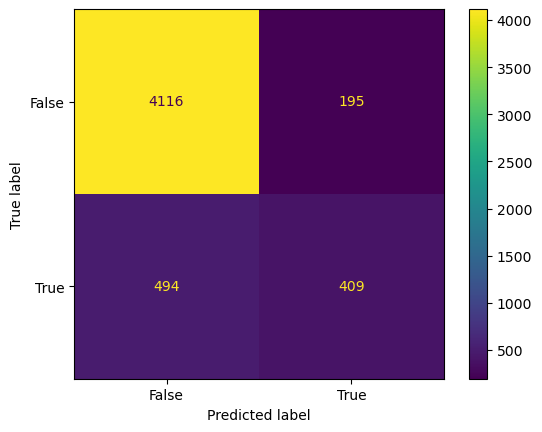

In [104]:
create_confusion_matrix(best_model, val_loader)

### Creating feature extractor

In [58]:
from torchvision.models.feature_extraction import get_graph_node_names
from torchvision.models.feature_extraction import create_feature_extractor

In [59]:
train_nodes, eval_nodes = get_graph_node_names(CNNImg())

C:\Users\bduser\anaconda3\Lib\site-packages\torch\overrides.py:110: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  torch.has_cuda,
C:\Users\bduser\anaconda3\Lib\site-packages\torch\overrides.py:111: UserWarning: 'has_cudnn' is deprecated, please use 'torch.backends.cudnn.is_available()'
  torch.has_cudnn,
C:\Users\bduser\anaconda3\Lib\site-packages\torch\overrides.py:117: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  torch.has_mps,
C:\Users\bduser\anaconda3\Lib\site-packages\torch\overrides.py:118: UserWarning: 'has_mkldnn' is deprecated, please use 'torch.backends.mkldnn.is_available()'
  torch.has_mkldnn,


In [73]:
feature_extractor = create_feature_extractor(custom_model, {'flat5':'feature_output'})
feature_extractor

CNNImg(
  (conv1): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (drop2): Dropout(p=0.2, inplace=False)
  (conv3): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool4): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (drop4): Dropout(p=0.2, inplace=False)
  (conv5): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool5): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (drop5): Dropout(p=0.2, inplace=False)
  (flat5): Flatten(start_dim=1, end_dim=-1)
)